Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/ml-frameworks/keras/train-hyperparameter-tune-deploy-with-keras/train-hyperparameter-tune-deploy-with-keras.png)

# Training, hyperparameter tune, and deploy with Keras

## Introduction
This tutorial shows how to train a simple deep neural network using the MNIST dataset and Keras on Azure Machine Learning. MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents, and deploy it as a web service in Azure.

For more information about the MNIST dataset, please visit [Yan LeCun's website](http://yann.lecun.com/exdb/mnist/).

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, go through the [configuration notebook](../../../../configuration.ipynb) to:
    * install the AML SDK
    * create a workspace and its configuration file (`config.json`)
* For local scoring test, you will also need to have `tensorflow` and `keras` installed in the current Jupyter kernel.

Let's get started. First let's import some Python libraries.

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.19.0


In [ ]:
from azureml.core import Workspace, Experiment, ScriptRunConfig

# get workspace
ws = Workspace.from_config()

# get compute target
target = ws.compute_targets['${1:target-name}']

# get registered environment
env = ws.environments['${2:env-name}']

# get/create experiment
exp = Experiment(ws, '${3:experiment_name}')

# set up script run configuration
config = ScriptRunConfig(
    source_directory='${4:.}',
    script='${5:script.py}',
    compute_target=target,
    environment=env,
    arguments=[${6:'--meaning', 42}],
)

# submit script to AML
run = exp.submit(config)
print(run.get_portal_url()) # link to ml.azure.com
run.wait_for_completion(show_output=True)

## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [3]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: shwinne-demos
Azure region: westus
Subscription id: 15ae9cb6-95c1-483d-a0e3-b1a1a3b06324
Resource group: PipelinesUsabilityStudy


## Create an Azure ML experiment
Let's create an experiment named "keras-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [4]:
from azureml.core import Experiment

script_folder = './keras-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='keras-mnist')

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the MNIST dataset
* Display some sample images

### Download the MNIST dataset

Download the MNIST dataset and save the files into a `data` directory locally.  Images and labels for both training and testing are downloaded.

In [5]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'))

('/mnt/batch/tasks/shared/LS_root/mounts/clusters/tinyboy/code/Users/shwinne/Demo/train-hyperparameter-tune-deploy-with-keras/data/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x7faa2cfc6080>)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compressed files into numpy arrays.

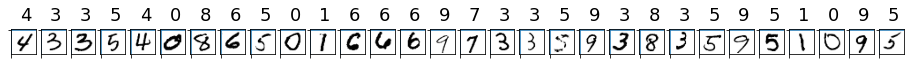

In [6]:
# make sure utils.py is in the same directory as this code
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images-idx3-ubyte.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the training set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

Now you have an idea of what these images look like and the expected prediction outcome.

## Create a FileDataset
A FileDataset references one or multiple files in your datastores or public urls. The files can be of any format. FileDataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [7]:
from azureml.core.dataset import Dataset
web_paths = ['https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

Use the `register()` method to register datasets to your workspace so they can be shared with others, reused across various experiments, and referred to by name in your training script.
You can try get the dataset first to see if it's already registered.

In [46]:
dataset = dataset.register(workspace = ws,
                               name = 'mnist-dataset',
                               description='training and test dataset',
                               create_new_version=True)

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [9]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "cpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_DS3_v2', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# can poll for a minimum number of nodes and for a specific timeout. 
# if no min node count is provided it uses the scale settings for the cluster
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-09-14T02:28:38.854000+00:00', 'errors': None, 'creationTime': '2020-09-09T19:57:51.775367+00:00', 'modifiedTime': '2020-09-09T19:58:09.398698+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 10, 'nodeIdleTimeBeforeScaleDown': 'PT7200S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named "gpu-cluster" of type `AmlCompute`.

In [10]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

gpu-cluster AmlCompute Failed
demo-cluster ComputeInstance Succeeded
cpu-cluster AmlCompute Succeeded
tinyboy ComputeInstance Succeeded


## Copy the training files into the script folder
The Keras training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [11]:
import shutil

# the training logic is in the keras_mnist.py file.
shutil.copy('./keras_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./keras-mnist/utils.py'

## Construct neural network in Keras
In the training script `keras_mnist.py`, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.

![DNN](nn.png)

### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the FileDataset in which the script can find the MNIST data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the loss and accuracy at the end of each epoch via callback.
```
    run.log('Loss', log['val_loss'])
    run.log('Accuracy', log['val_accuracy'])
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

The next cell will print out the training code for you to inspect.

In [12]:
with open(os.path.join(script_folder, './keras_mnist.py'), 'r') as f:
    print(f.read())

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import argparse
import os
import glob

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.callbacks import Callback

import tensorflow as tf

from azureml.core import Run
from utils import load_data, one_hot_encode

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', default='data', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--first-layer-neurons', type=int, dest='n_hidden_1', default=100,
                    help='# of neurons in the first layer')
parser.add_argument('--second-layer-neur

## Create an environment

Define a conda environment YAML file with your training script dependencies, which include TensorFlow, Keras and matplotlib, and create an Azure ML environment.

In [13]:
%%writefile conda_dependencies.yml

channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - h5py<=2.10.0
  - azureml-defaults
  - tensorflow-gpu==2.0.0
  - keras<=2.3.1
  - matplotlib

Overwriting conda_dependencies.yml


In [14]:
from azureml.core import Environment

keras_env = Environment.from_conda_specification(name = 'keras-2.3.1', file_path = './conda_dependencies.yml')

# Specify a GPU base image
keras_env.docker.enabled = True
keras_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'

## Configure the training job

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on.

Note that we are specifying a DatasetConsumptionConfig for our FileDataset as an argument to the training script. Azure ML will resolve this DatasetConsumptionConfig to the mount-point of the backing datastore, which we access from the training script.

In [15]:
dataset = Dataset.get_by_name(ws, 'mnist-dataset')

# list the files referenced by mnist dataset
dataset.to_path()

['/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz']

In [16]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', dataset.as_named_input('mnist').as_mount(),
        '--batch-size', 50,
        '--first-layer-neurons', 300,
        '--second-layer-neurons', 100,
        '--learning-rate', 0.001]

src = ScriptRunConfig(source_directory=script_folder,
                      script='keras_mnist.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env)

## Submit job to run
Submit the ScriptRunConfig to the Azure ML experiment to kick off the execution.

In [17]:
run = exp.submit(src)

### Monitor the Run
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the Azure ML environment, and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the AmlCompute cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [18]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [19]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
keras-mnist,keras-mnist_1607930880_3302a46a,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
run.wait_for_completion(show_output=True)

RunId: keras-mnist_1607930880_3302a46a
Web View: https://ml.azure.com/experiments/keras-mnist/runs/keras-mnist_1607930880_3302a46a?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/PipelinesUsabilityStudy/workspaces/shwinne-demos

Streaming azureml-logs/20_image_build_log.txt

2020/12/14 07:28:07 Downloading source code...
2020/12/14 07:28:08 Finished downloading source code
2020/12/14 07:28:09 Creating Docker network: acb_default_network, driver: 'bridge'
2020/12/14 07:28:09 Successfully set up Docker network: acb_default_network
2020/12/14 07:28:09 Setting up Docker configuration...
2020/12/14 07:28:10 Successfully set up Docker configuration
2020/12/14 07:28:10 Logging in to registry: 433acf81ccde4cb988855759798e2639.azurecr.io
2020/12/14 07:28:11 Successfully logged into 433acf81ccde4cb988855759798e2639.azurecr.io
2020/12/14 07:28:11 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2020/12/14 07:28:11 Sca

In the outputs of the training script, it prints out the Keras version number. Please make a note of it.

### The Run object
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [ ]:
run.get_details()

In [ ]:
run.get_metrics()

In [ ]:
run.get_file_names()

## Download the saved model

In the training script, the Keras model is saved into two files, `model.json` and `model.h5`, in the `outputs/models` folder on the gpu-cluster AmlCompute node. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `run` object to download the model files. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`.

In [ ]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

## Predict on the test set (Optional)
Let's check the version of the local Keras. Make sure it matches with the version number printed out in the training script. Otherwise you might not be able to load the model properly.

    import keras
    import tensorflow as tf

    print("Keras version:", keras.__version__)
    print("Tensorflow version:", tf.__version__)

Now let's load the downloaded model.

    from keras.models import model_from_json

    # load json and create model
    json_file = open('model/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model/model.h5")
    print("Model loaded from disk.")

Feed test dataset to the persisted model to get predictions.

    # evaluate loaded model on test data
    loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    y_test_ohe = one_hot_encode(y_test, 10)
    y_hat = np.argmax(loaded_model.predict(X_test), axis=1)

    # print the first 30 labels and predictions
    print('labels:  \t', y_test[:30])
    print('predictions:\t', y_hat[:30])

Calculate the overall accuracy by comparing the predicted value against the test set.

    print("Accuracy on the test set:", np.average(y_hat == y_test))

## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)

Next, we will create a new ScriptRunConfig without the above arguments since they will be passed in later by our Hyperdrive configuration. Note we still need to keep the `data-folder` parameter since that's not a hyperparameter we will sweep.

In [ ]:
args = ['--data-folder', dataset.as_named_input('mnist').as_mount()]

src = ScriptRunConfig(source_directory=script_folder,
                      script='keras_mnist.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env)

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [ ]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `Accuracy` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [ ]:
hyperdrive_config = HyperDriveConfig(run_config=src,
                                     hyperparameter_sampling=ps,
                                     policy=policy,
                                     primary_metric_name='Accuracy',
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                     max_total_runs=20,
                                     max_concurrent_runs=4)

Finally, let's launch the hyperparameter tuning job.

In [ ]:
hyperdrive_run = exp.submit(config=hyperdrive_config)

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [ ]:
RunDetails(hyperdrive_run).show()

In [ ]:
hyperdrive_run.wait_for_completion(show_output=True)

In [ ]:
assert(hyperdrive_run.get_status() == "Completed")

### DEMO STOPS HERE